# Implementation of Audio Spectrogram Transformer (AST) model

For our project, we wanted to train and test an existing transformer model. After some research, we settled on the AST model. 

Here is an extract from the documentation:

- The Audio Spectrogram Transformer applies a Vision Transformer to audio, by turning audio into an image (spectrogram). The model obtains state-of-the-art results for audio classification

We will show you how we adapted AST to our problem and the results we obtained with this model.

## Import

In [1]:
!pip install librosa tensorflow transformers torch tf-keras
!pip show transformers tensorflow keras

import os

import numpy as np

import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from transformers import AutoFeatureExtractor, ASTForAudioClassification

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from datetime import datetime

print("Done!")


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Name: transformers
Version: 4.46.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /Users/loic/Documents/Ulaval/TraitementSignal/Projet/projet_ift_7030/.venv/lib/python3.12/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
---
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/loic/Documen

/Users/loic/Documents/Ulaval/TraitementSignal/Projet/projet_ift_7030/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done!


## Segment extraction and dataset creation

The `segment_audio` function processes an audio file and its corresponding label file, which contains timestamps and positions. It first loads the audio and resamples it to a target sampling rate of 16kHz. The function then reads the label file, converting the timestamps into total seconds since midnight, and calculates the speed for each segment by computing the difference in positions divided by the segment length. The audio is segmented based on these time intervals, and segments that are too short or empty are discarded. The function returns a list of audio segments paired with their corresponding speed values, which are then used for model training and evaluation.

In [2]:
target_sr = 16000

def parse_time(time_str):
    """
    Convertit une chaîne de temps au format "%Y-%m-%d_%H-%M-%S-%f" en secondes totales depuis le début de la journée.
    """
    dt = datetime.strptime(time_str, "%Y-%m-%d_%H-%M-%S-%f")
    total_seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
    return dt, total_seconds  # Retourne l'objet datetime et le nombre total de secondes

def segment_audio(file_path, label_file):
    y, sr = librosa.load(file_path, sr=None)
    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    labels = []
    for line in lines[1:]:
        if(" | " not in line):
            continue
        time_str, position = line.strip().split(' | ')
        dt, total_seconds = parse_time(time_str)
        labels.append([dt, total_seconds, float(position)])
    labels = np.array(labels)
    
    times = labels[:, 1]  # Total seconds since midnight
    dates = labels[:, 0]  # Datetime objects
    positions = labels[:, 2]  # Positions
    
    segments_with_speed = []
    cursor = 0  # Start at the beginning of the audio file
    
    imax = len(times) - 1
    while(imax % 10 != 0 ):
        imax = imax - 1
    for i in range(0, imax, 10):
        start_time = times[i]
        end_time = times[i + 10]
        start_date = dates[i]
        end_date = dates[i + 10]
        
        # Check for day change
        if end_date.date() > start_date.date():
            segment_length = (86400 - start_time) + end_time  # 86400 seconds in a day
        else:
            segment_length = end_time - start_time
        
        end_sample = cursor + int(segment_length * target_sr)
        
        if cursor >= end_sample or segment_length < 0.1:
            print(f"Warning: Empty or realy small segment detected. Cursor: {cursor}, End: {end_sample}")
            continue
        
        segment = y[cursor:end_sample]
        speed = (positions[i+10] - positions[i]) / segment_length
        
        #Text file longer than audio file trigger this or sometime last segment is too small
        if(len(segment) == 0 or segment.shape[0] < 15660):
            continue

        segments_with_speed.append((segment, speed))
        
        cursor = end_sample  # Move cursor to the start of the next segment
    
    return segments_with_speed


## Normalization speed

We normalize speeds to a scale between 0 and 1 using the normalize_speed function:

- We retrieve the speeds in segments_and_speeds extracted via the segment_audio function.

- Then we apply this normalization by dividing by the maximum speed, using np.clip to avoid values greater than 1.

This is suitable for regression where we want to predict continuous values between 0 and 1 (for example, the normalized motor speed). This is a good approach, as regression models work best when target values are on a uniform scale.

In [3]:
def normalize_speed(speeds):
    """
    Normalize a value between 0 and 1
    """
    max_speed = max(speeds)  # Maximum speed in your dataset
    min_speed = 0    # Minimum speed in your dataset
    
    print(f"Min speed: {min_speed}; Max speed: {max_speed}")
    
    # Ensure speeds are numpy array for vectorized operations
    speeds = np.array(speeds)
    
    # Normalize speeds
    normalized_speeds = np.clip(speeds / max_speed, 0, 1)
    
    print(f"Normalized speeds: {normalized_speeds}")
    
    return normalized_speeds

# def speed_to_class(normalized_speeds, num_classes=20):
#     """
#     Convert normalized speeds (0 to 1) into discrete classes.
#     """
#     class_intervals = np.linspace(0, 1, num_classes + 1)  # Create class boundaries
#     class_labels = np.digitize(normalized_speeds, class_intervals) - 1  # Classify based on intervals
#     return class_labels


## Segmentation

Beacause we are using big audio files, we need to segment them to compute.

This code processes a directory containing audio files (.wav) and their corresponding label files (.txt). It first loads the segments and speeds using the `segment_audio` function, which segments the audio based on timestamps and calculates the speed of each segment. The audio segments are then normalized by truncating them to the same length and scaling them so that the maximum absolute value is 1. The corresponding speeds are normalized to a [0, 1] range.

In [4]:
# Process the directory
directory = "DataForPreprocessing/"
segments_and_speeds = []
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        filepath = os.path.join(directory, filename)
        segments_and_speeds.extend(segment_audio(filepath, filepath[:-3] + "txt"))

# Split into segments and speeds
segments, speeds = zip(*segments_and_speeds)

# Normalize the segments audio
min_len = min(len(segment) for segment in segments)
truncated_segments = [segment[:min_len] for segment in segments]
np_segments = np.vstack(truncated_segments)
max_val = np.max(np.abs(np_segments))
normalized_segments = np_segments / max_val

print(f"Segments shape: {np_segments.shape}")
print(f"Max value: {max_val}")

# Normalize the speeds
normalized_speeds = normalize_speed(speeds)

# Apply class conversion to normalized speeds
# class_labels = speed_to_class(normalized_speeds)

Segments shape: (11109, 16038)
Max value: 0.136061429977417
Min speed: 0; Max speed: 2.536722781350826
Normalized speeds: [0.         0.11304874 0.16498043 ... 0.18885802 0.18876974 0.18876938]


## Creation spectrograms and data preparation for AST

This code converts audio segments into spectrograms using the AutoFeatureExtractor (`AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")`) from the pre-trained AST model. To optimize the computation and reduce memory usage, the number of Mel bins is reduced to 64, the window length is set to 400 samples, and the hop length is increased to 160 to reduce the temporal resolution. The features (spectrograms) for each audio segment are extracted and stored in a list. These features are then converted into a numpy array for training purposes. The dataset is split into training and testing sets, and the features are converted into PyTorch tensors. 

A DataLoader is created for batch processing during training with a batch size of 8. We can change this value, but we set it to 8 for a question of material calculation resources.

The dataset is now ready for model training.

In [5]:

# Convertir les segments audio en spectrogrammes via l'extracteur
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
feature_extractor.mel_bins = 64  # Réduire le nombre de bins de Mel
feature_extractor.window_length = 400  # Réduire la longueur de la fenêtre (en échantillons)
feature_extractor.hop_length = 160  # Augmenter la longueur du hop pour réduire la taille temporelle

features_list = []
for i, segment in enumerate(segments):
    inputs = feature_extractor(segment, sampling_rate=16000, return_tensors="pt")
    features = inputs["input_values"].squeeze(0)  # Extraire les features (spectrogrammes)
    features_list.append(features)
  
# Convertir les features en un tableau numpy pour l'entraînement
normalized_audio_features = np.array([features.numpy() for features in features_list])
print(f"Features shape: {normalized_audio_features.shape}")

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(normalized_audio_features, normalized_speeds, test_size=0.2, random_state=42)

# Conversion des features en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Créer le DataLoader pour l'entraînement
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) 

Features shape: (11109, 1024, 128)


## Training the model

We will use the model `MIT/ast-finetuned-audioset-10-10-0.4593` from the Hugging Face model hub. This model has been fine-tuned on the AudioSet dataset and achieves good performance on audio classification tasks.

We set up a pre-trained ASTForAudioClassification model on AudioSet with Hugging Face. Then we replace its last layer to predict a single continuous value (normalized speed in this case). This is a correct modification, as the AST model has an output that is typically used for classification (several classes)

In [6]:
# Load the model and processor
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Modify the output layer of the model
in_features = model.classifier.dense.in_features
model.classifier = nn.Linear(in_features, 1)

# Vérifiez si un GPU avec CUDA est disponible
if torch.cuda.is_available():
    device = torch.device("cuda")  # Utiliser le GPU si disponible
    print("CUDA is available. Using GPU.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Utiliser le GPU sur Mac avec MPS
    print("MPS is available. Using MPS.")
else:
    device = torch.device("cpu")  # Utiliser le CPU si aucun GPU n'est disponible
    print("Using CPU.")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3 

for epoch in range(epochs):
    count = 0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).logits.squeeze(1)  # Accéder aux logits et les aplatir
        # Calculer la perte
        loss = criterion(y_pred, y_batch)  # Comparer les prédictions avec les valeurs réelles
        loss.backward()
        optimizer.step()
        print(f"Count {count+1} / {len(train_loader)}")
        count += 1

    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

MPS is available. Using MPS.
Count 1 / 1111
Count 2 / 1111
Count 3 / 1111
Count 4 / 1111
Count 5 / 1111
Count 6 / 1111
Count 7 / 1111
Count 8 / 1111
Count 9 / 1111
Count 10 / 1111
Count 11 / 1111
Count 12 / 1111
Count 13 / 1111
Count 14 / 1111
Count 15 / 1111
Count 16 / 1111
Count 17 / 1111
Count 18 / 1111
Count 19 / 1111
Count 20 / 1111
Count 21 / 1111
Count 22 / 1111
Count 23 / 1111
Count 24 / 1111
Count 25 / 1111
Count 26 / 1111
Count 27 / 1111
Count 28 / 1111
Count 29 / 1111
Count 30 / 1111
Count 31 / 1111
Count 32 / 1111
Count 33 / 1111
Count 34 / 1111
Count 35 / 1111
Count 36 / 1111
Count 37 / 1111
Count 38 / 1111
Count 39 / 1111
Count 40 / 1111
Count 41 / 1111
Count 42 / 1111
Count 43 / 1111
Count 44 / 1111
Count 45 / 1111
Count 46 / 1111
Count 47 / 1111
Count 48 / 1111
Count 49 / 1111
Count 50 / 1111
Count 51 / 1111
Count 52 / 1111
Count 53 / 1111
Count 54 / 1111
Count 55 / 1111
Count 56 / 1111
Count 57 / 1111
Count 58 / 1111
Count 59 / 1111
Count 60 / 1111
Count 61 / 1111
Coun

## Evaluation

In [7]:
model.eval()

batch_size = 8
y_preds = []
for i in range(0, len(X_test_tensor), batch_size):
    batch = X_test_tensor[i:i+batch_size]
    outputs = model(batch)
    y_pred_batch = outputs.logits.detach().numpy().squeeze()
    y_preds.append(y_pred_batch)
    print(f"Batch {i // batch_size + 1} / {len(X_test_tensor) // batch_size}")
y_pred = np.concatenate(y_preds, axis=0)
print(f"Predictions: {y_pred}")

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f'R-squared Score: {r2}')

Batch 1 / 277
Batch 2 / 277
Batch 3 / 277
Batch 4 / 277
Batch 5 / 277
Batch 6 / 277
Batch 7 / 277
Batch 8 / 277
Batch 9 / 277
Batch 10 / 277
Batch 11 / 277
Batch 12 / 277
Batch 13 / 277
Batch 14 / 277
Batch 15 / 277
Batch 16 / 277
Batch 17 / 277
Batch 18 / 277
Batch 19 / 277
Batch 20 / 277
Batch 21 / 277
Batch 22 / 277
Batch 23 / 277
Batch 24 / 277
Batch 25 / 277
Batch 26 / 277
Batch 27 / 277
Batch 28 / 277
Batch 29 / 277
Batch 30 / 277
Batch 31 / 277
Batch 32 / 277
Batch 33 / 277
Batch 34 / 277
Batch 35 / 277
Batch 36 / 277
Batch 37 / 277
Batch 38 / 277
Batch 39 / 277
Batch 40 / 277
Batch 41 / 277
Batch 42 / 277
Batch 43 / 277
Batch 44 / 277
Batch 45 / 277
Batch 46 / 277
Batch 47 / 277
Batch 48 / 277
Batch 49 / 277
Batch 50 / 277
Batch 51 / 277
Batch 52 / 277
Batch 53 / 277
Batch 54 / 277
Batch 55 / 277
Batch 56 / 277
Batch 57 / 277
Batch 58 / 277
Batch 59 / 277
Batch 60 / 277
Batch 61 / 277
Batch 62 / 277
Batch 63 / 277
Batch 64 / 277
Batch 65 / 277
Batch 66 / 277
Batch 67 / 277
Batc

Mean Absolute Error: 0.051562726933428116
Mean Squared Error: 0.004005229012343433
Root Mean Squared Error: 0.06328687867436214
R-squared Score: 0.943182094956121
Median Absolute Error: 0.04535995924905047


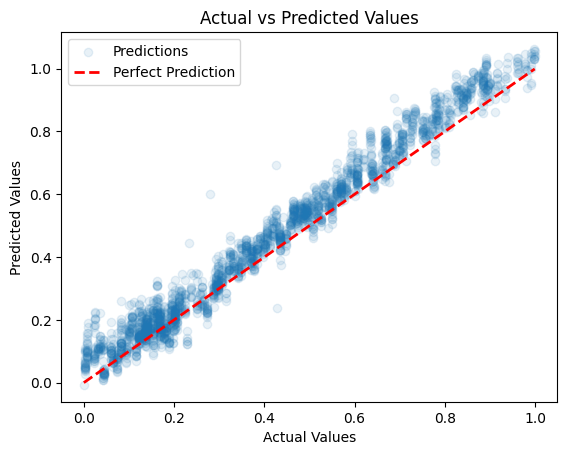

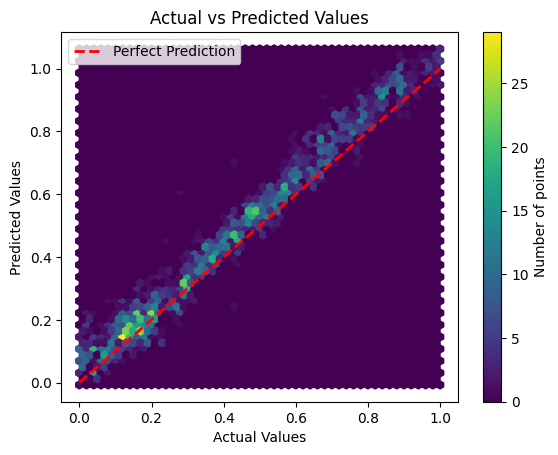

In [8]:
import matplotlib.pyplot as plt
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2}')

#epsilon = 1e-15  # A very small number
#mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
#print(f'Mean Absolute Percentage Error: {mape}%')

medae = np.median(np.abs(y_test - y_pred))
print(f'Median Absolute Error: {medae}')

plt.scatter(y_test, y_pred, label='Predictions', alpha=0.1)

#hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
#plt.colorbar(hb, label='Number of points')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

# Add legend
plt.legend(loc='upper left')

# Ensure the axes are equal for a better visual comparison
#plt.axis('equal')

plt.show()


hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
plt.colorbar(hb, label='Number of points')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

# Add legend
plt.legend(loc='upper left')

# Ensure the axes are equal for a better visual comparison
#plt.axis('equal')

plt.show()